ใน ep นี้เราจะมาสร้าง Recurrent Neural Network (RNN) กันแต่ต้น เริ่มตั้งแต่พื้นฐาน แล้วค่อย ๆ พัฒนาโมเดล แก้ไขข้อจำกัดของโมเดลแต่ละแบบ พัฒนาไปจนถึงต่อยอดด้วย โมเดลที่ซับซ้อน เช่น GRU เปรียบเทียบประสิทธิภาพ Before / After ของแต่ละ Design การออกแบบ Model Architecture

# 0. Install

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Install Library ที่จำเป็น

In [0]:
## Colab
! curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


เช็ค GPU

In [0]:
! nvidia-smi

Fri Dec 13 08:03:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Import

Import Library ที่จะใช้ ในที่นี้คือ fastai และ fastai.text 

In [0]:
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.callbacks.mem import *

In [0]:
# import fastai.utils.collect_env
# fastai.utils.collect_env.show_install()

สำหรับ [Google Colab](https://www.bualabs.com/archives/1687/what-is-colab-open-jupyter-notebook-in-github-on-google-colab-create-open-in-colab-button-colab-ep-1/) เราจะกำหนด path ที่เก็บ DataSet และ Mount Google Drive 

In [0]:
dataset = 'HUMAN_NUMBERS'

# Google Colab
config_path = Path('/content/drive')
data_path_base = Path('/content/datasets/')

data_path = data_path_base/dataset

from google.colab import drive
drive.mount(str(config_path))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Dataset

ในเคสนี้เราจะใช้ Human Numbers คือ รายการตัวเลข เขียนเป็นภาษาอังกฤษ 

In [0]:
path = untar_data(URLs.HUMAN_NUMBERS, dest=data_path)
path.ls()

[PosixPath('/content/datasets/HUMAN_NUMBERS/human_numbers/train.txt'),
 PosixPath('/content/datasets/HUMAN_NUMBERS/human_numbers/valid.txt')]

In [0]:
! head {path}/train.txt

one 
two 
three 
four 
five 
six 
seven 
eight 
nine 
ten 


In [0]:
! tail {path}/train.txt

seven thousand nine hundred ninety 
seven thousand nine hundred ninety one 
seven thousand nine hundred ninety two 
seven thousand nine hundred ninety three 
seven thousand nine hundred ninety four 
seven thousand nine hundred ninety five 
seven thousand nine hundred ninety six 
seven thousand nine hundred ninety seven 
seven thousand nine hundred ninety eight 
seven thousand nine hundred ninety nine 


In [0]:
! head {path}/valid.txt

eight thousand one 
eight thousand two 
eight thousand three 
eight thousand four 
eight thousand five 
eight thousand six 
eight thousand seven 
eight thousand eight 
eight thousand nine 
eight thousand ten 


In [0]:
! tail {path}/valid.txt

nine thousand nine hundred ninety 
nine thousand nine hundred ninety one 
nine thousand nine hundred ninety two 
nine thousand nine hundred ninety three 
nine thousand nine hundred ninety four 
nine thousand nine hundred ninety five 
nine thousand nine hundred ninety six 
nine thousand nine hundred ninety seven 
nine thousand nine hundred ninety eight 
nine thousand nine hundred ninety nine 


# 3. Preprocessing

## 3.1 อ่านไฟล์

ประกาศฟังก์ชัน สำหรับอ่านไฟล์มารวมคั่นด้วย Comma ใส่ List ไว้

In [0]:
def readnums(d): return [', '.join(o.strip() for o in open(path/d).readlines())]

In [0]:
train_txt = readnums('train.txt')
train_txt[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [0]:
valid_txt = readnums('valid.txt')
valid_txt[0][:80]

'eight thousand one, eight thousand two, eight thousand three, eight thousand fou'

## 3.2 Data Pipeline

สร้าง TextList (ItemList) ทั้ง [Training Set และ Validation Set](https://www.bualabs.com/archives/532/what-is-training-set-why-train-test-split-training-set-validation-set-test-set/)

In [0]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

train, valid

รวม 2 Splitted ItemList ที่เราสร้างไว้

In [0]:
splitted = ItemLists(path=path, train=train, valid=valid)
splitted

ใส่ Label สำหรับ Language Model ให้ทั้ง 2 ItemList

In [0]:
labeled_splitted = splitted.label_for_lm()
labeled_splitted

สร้าง DataBunch

In [0]:
data = labeled_splitted.databunch()
data

## 3.3 เช็คข้อมูล

จำนวน Token (ความยาว) ของ ข้อมูลตัวอย่าง x ตัวแรก ใน Validation Set

In [0]:
len(data.valid_ds[0][0].data)

13017

Backpropagation Through Time (BPTT) คือ มิติของเวลา ว่าจะเทรนไปกี่ Token ถึงจะทำ Backpropagation หา [Gradient](https://www.bualabs.com/archives/631/what-is-gradient-descent-in-deep-learning-what-is-stochastic-gradient-descent-sgd-optimization-ep-1/) เรียก [Optimizer Step](https://www.bualabs.com/archives/2042/refactor-parameter-optimizer-neural-network-train-deep-learning-machine-learning-neural-network-ep-6/) อัพเดท Weight ของโมเดล

และจำนวน Batch ใน Validation Set

In [0]:
data.bptt, len(data.valid_dl)

(70, 3)

กำหนด [Batch Size](https://www.bualabs.com/archives/729/what-is-batch-size-in-deep-neural-networks-how-to-adjust-machine-learning-model-accuracy-deep-learning-hyperparameter-tuning-ep-2/) = 64

In [0]:
bs=64

นำข้อมูลตัวอย่าง มาหารด้วยความยาว BPTT ว่าจะใส่ข้อความยาวเท่าไร และ Batch Size ว่าจะแบ่งเป็นกี่ข้อความ ที่จะ Feed ใส่พร้อม ๆ กัน

คำนวนได้ประมาณ 3 Mini-Batch ใน 1 Epoch ของ [Training Loop](https://www.bualabs.com/archives/1985/basic-training-loop-start-train-neural-network-mini-batch-sgd-neural-network-ep-4/)

In [0]:
13017/70/bs

2.905580357142857

เราจะใช้ Iterator แบ่ง Validation Set ออกมาเป็น x, y 3 ชุดเลย จะได้เห็นชัด ๆ

In [0]:
it = iter(data.valid_dl)

x1, y1 = next(it)
x2, y2 = next(it)
x3, y3 = next(it)

it.close()

จะได้ ข้อมูล x ขนาด Batch Size x BPTT ออกมา และ Label y เท่ากับ x ตัวถัดไป สำหรับเทรน Language Model

In [0]:
x1.shape, y1.shape, x1[0, :10], y1[0, :10]

(torch.Size([64, 70]),
 torch.Size([64, 70]),
 tensor([ 2, 19, 11, 12,  9, 19, 11, 13,  9, 19], device='cuda:0'),
 tensor([19, 11, 12,  9, 19, 11, 13,  9, 19, 11], device='cuda:0'))

เช็คว่าครบไหม พบว่าเกิน

numel = Number of Elements

In [0]:
x1.numel() + x2.numel() + x3.numel()

13440

เพราะมีการใส่ Padding ให้ความยาวเท่ากันทุก Batch

In [0]:
x1.numel(), x2.numel(), x3.numel()

(4480, 4480, 4480)

## 3.4 ดูข้อมูล Explore Data

ดูรายการคำศัพท์ทั้งหมด ใน vocab Dictionary 

In [0]:
v = data.valid_ds.vocab

In [0]:
v.itos

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 'hundred',
 'thousand',
 'one',
 'two',
 'three',
 'four',
 'five',
 'six',
 'seven',
 'eight',
 'nine',
 'twenty',
 'thirty',
 'forty',
 'fifty',
 'sixty',
 'seventy',
 'eighty',
 'ninety',
 'ten',
 'eleven',
 'twelve',
 'thirteen',
 'fourteen',
 'fifteen',
 'sixteen',
 'seventeen',
 'eighteen',
 'nineteen',
 'xxfake']

In [0]:
x1[0, :]

tensor([ 2, 19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19,
        11, 16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,
         9, 19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19,
        11, 33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19],
       device='cuda:0')

In [0]:
y1[0, :]

tensor([19, 11, 12,  9, 19, 11, 13,  9, 19, 11, 14,  9, 19, 11, 15,  9, 19, 11,
        16,  9, 19, 11, 17,  9, 19, 11, 18,  9, 19, 11, 19,  9, 19, 11, 20,  9,
        19, 11, 29,  9, 19, 11, 30,  9, 19, 11, 31,  9, 19, 11, 32,  9, 19, 11,
        33,  9, 19, 11, 34,  9, 19, 11, 35,  9, 19, 11, 36,  9, 19, 11],
       device='cuda:0')

In [0]:
v.itos[13], v.itos[9], v.itos[14], v.itos[10], v.itos[13], v.itos[9], v.itos[15], v.itos[10] 

('two', ',', 'three', 'hundred', 'two', ',', 'four', 'hundred')

ดูเป็นข้อความ Text

In [0]:
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [0]:
v.textify(x1[1])

', eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine ,'

In [0]:
v.textify(y1[1])

'eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight'

In [0]:
v.textify(x2[0])

'thousand eighteen , eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two ,'

In [0]:
v.textify(x3[0])

'eight thousand thirty three , eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine , eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty five , eight thousand forty six , eight'

In [0]:
v.textify(x3[-1])

'ninety , nine thousand nine hundred ninety one , nine thousand nine hundred ninety two , nine thousand nine hundred ninety three , nine thousand nine hundred ninety four , nine thousand nine hundred ninety five , nine thousand nine hundred ninety six , nine thousand nine hundred ninety seven , nine thousand nine hundred ninety eight , nine thousand nine hundred ninety nine xxbos eight thousand one , eight'

In [0]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty"
1,"eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand one hundred one , eight thousand one"
2,"thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one hundred thirty three , eight thousand"
3,"three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two , eight thousand one hundred sixty three"
4,"thousand one hundred eighty three , eight thousand one hundred eighty four , eight thousand one hundred eighty five , eight thousand one hundred eighty six , eight thousand one hundred eighty seven , eight thousand one hundred eighty eight , eight thousand one hundred eighty nine , eight thousand one hundred ninety , eight thousand one hundred ninety one , eight thousand one hundred ninety two , eight thousand"


# 4. Model

## 4.1 Fully Connected Model 1 Layer

In [0]:
data = labeled_splitted.databunch(bs=bs, bptt=3)
data

In [0]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [0]:
x[:10, :], y[:10, :]

(tensor([[13,  9, 14],
         [13, 10, 30],
         [10, 26, 17],
         [ 9, 16, 10],
         [18, 10, 20],
         [ 9, 19, 10],
         [11, 23, 13],
         [11, 12, 10],
         [13, 10, 28],
         [19,  9, 12]]), tensor([[ 9, 14,  9],
         [10, 30,  9],
         [26, 17,  9],
         [16, 10, 23],
         [10, 20,  9],
         [19, 10, 26],
         [23, 13,  9],
         [12, 10, 26],
         [10, 28, 12],
         [ 9, 12, 11]]))

nv = Number of vocab

In [0]:
nv = len(v.itos); nv

40

nh = Number of Hidden 

In [0]:
nh = 64

ประกาศ Loss Function ที่จะคิดเฉพาะผลของ Step ท้ายสุด ภายในเป็น [Cross Entropy Loss](https://www.bualabs.com/archives/1945/what-is-cross-entropy-loss-logistic-regression-log-loss-loss-function-ep-3/) ที่เหมาะกับงาน Classification

In [0]:
def loss4(input, target): return F.cross_entropy(input, target[:, -1])

ประกาศฟังก์ชัน คำนวน [Metric](https://www.bualabs.com/archives/1968/what-is-metrics-confusion-matrix-accuracy-precision-recall-f1-score-difference-metrics-ep-1/)  ที่จะคิดเฉพาะผลของ Step ท้ายสุด ภายในเป็น Accuracy ธรรมดา

In [0]:
def acc4(input, target): return accuracy(input, target[:, -1])

In [0]:
x[:, 0]

tensor([13, 13, 10,  9, 18,  9, 11, 11, 13, 19, 16, 23, 24,  9, 12,  9, 13, 14,
        15, 11, 10, 22, 15,  9, 10, 14, 11, 16, 10, 28, 11,  9, 20,  9, 15, 15,
        11, 18, 10, 28, 23, 24,  9, 16, 10, 16, 19, 20, 12, 10, 22, 16, 17, 17,
        17, 11, 24, 10,  9, 15, 16,  9, 18, 11])

สร้าง โมเดล [Artificial Neural Network](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) โดยมี Layer ดังนี้

1. i_h input to hidden
1. h_h hidden to hidden
1. h_o hidden to output
1. bn [BatchNorm](https://www.bualabs.com/archives/2617/what-is-batchnorm-teach-batch-normalization-train-machine-learning-model-deep-convolutional-neural-network-convnet-ep-5/)

เนื่องจากเรา fix bptt ไว้ที่ 3 ใน forward เราจะเช็คความยาวของ BPTT แล้วทำ Forward เอง ทีละขั้น เพื่อเวลา Backprop จะได้ Backprop ตามนั้น

In [0]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)

    def forward(self, x):
        h = self.bn(F.relu(self.i_h(x[:, 0])))
        if x.shape[1] > 1:
            h = h + self.i_h(x[:, 1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h = h + self.i_h(x[:, 2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data, Model0(), loss_func=loss4, metrics=[acc4], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,acc4,time
0,3.717673,3.650445,0.105699,00:01
1,3.054797,3.032577,0.388327,00:01
2,2.292718,2.450773,0.461167,00:01
3,1.938743,2.198278,0.461397,00:02
4,1.782156,2.114701,0.456112,00:01
5,1.713506,2.090328,0.457031,00:01
6,1.687654,2.085071,0.444623,00:01
7,1.682089,2.084593,0.444623,00:01


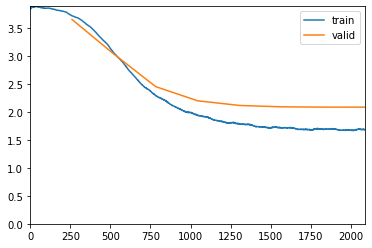

In [0]:
learn.fit_one_cycle(8, max_lr=1e-4)

## 4.2 RNN 

เราจะเปลี่ยนจาก Fully Connected Model 1 Layer โดย Refactor ใน forward จากใช้ If ไปใช้ Loop แทน ได้เป็น Recurrent Neural Network (RNN)

In [0]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)

    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:, i])
            # h = self.bn(F.relu(h))
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data, Model1(), loss_func=loss4, metrics=[acc4], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,acc4,time
0,3.701579,3.743782,0.053309,00:02
1,2.998606,3.002945,0.342371,00:02
2,2.284274,2.380152,0.453355,00:02
3,1.922181,2.110960,0.466912,00:02
4,1.758694,2.023635,0.463235,00:02
5,1.687768,2.000591,0.453585,00:02
6,1.661292,1.998328,0.440947,00:01
7,1.655519,1.998725,0.440947,00:02


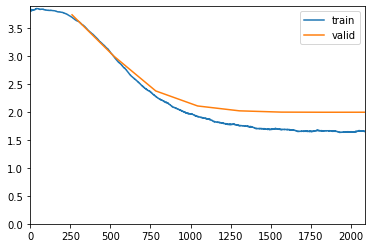

In [0]:
learn.fit_one_cycle(8, max_lr=1e-4)

## 4.3 RNN v2

Loss Function และ Metric ด้านบน จะคิดเฉพาะ Step สุดท้ายเท่านั้น เราจะเปลี่ยนกลับมาใช้ Cross Entrophy Loss และ Accuracy ปกติ ที่นำ Output จากทุก Step มาคิด

คราวนี้เราสามารถใช้ BPTT ยาวขึ้นได้

In [0]:
data = labeled_splitted.databunch(bs=bs, bptt=20)
data

In [0]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [0]:
y[0], x[0]

(tensor([30,  9, 31,  9, 32,  9, 33,  9, 34,  9, 35,  9, 36,  9, 37,  9, 38,  9,
         21,  9]),
 tensor([ 9, 30,  9, 31,  9, 32,  9, 33,  9, 34,  9, 35,  9, 36,  9, 37,  9, 38,
          9, 21]))

In [0]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)

    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))            
            o = self.h_o(self.bn(h))
            res.append(o)
            # print(o.shape)
        return torch.stack(res, dim=1)

ใช้ accuracy แทน acc4 และ Loss Function เป็น Cross Entrophy โดย default

In [0]:
learn = Learner(data, Model2(), metrics=[accuracy], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.799586,3.876884,0.022301,00:00
1,3.733685,3.797432,0.030469,00:00
2,3.579090,3.660543,0.091406,00:00
3,3.360449,3.518141,0.177060,00:01
4,3.133600,3.388465,0.233594,00:01
5,2.934809,3.281665,0.264773,00:01
6,2.779546,3.206280,0.281321,00:01
7,2.670803,3.162859,0.283665,00:01
8,2.603894,3.145651,0.286293,00:00
9,2.568911,3.143039,0.286435,00:01


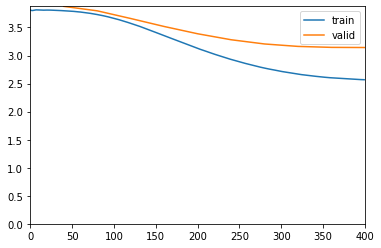

In [0]:
learn.fit_one_cycle(10, max_lr=1e-4)

จะเห็นว่า Accuracy ลดลง เนื่องจากต้อง Predict เยอะขึ้นกว่าเดิมมาก โมเดลจะต้อง Predict คำศัพท์จากอดีต 0-70 Token ยิ่งคำแรก ๆ ยิ่งมีอดีตให้เรียนรู้ได้น้อย

ทางแก้ก็คือ เราจะให้โมเดลจำ Hidden State ไว้ ข้าม Batch

## 4.4 RNN v3

เราจะให้โมเดลจำ Hidden State ไว้ ข้าม Batch ด้วยการกำหนดให้ h เป็นส่วนหนึ่งของโมเดล `self.h`

In [0]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh)

    def forward(self, x):
        h = self.h.to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:, i])
            h = F.relu(self.h_h(h))            
            res.append(self.bn(h))
        self.h = h.detach()        
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [0]:
learn = Learner(data, Model3(), metrics=[accuracy], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.628184,3.533759,0.136364,00:00
1,3.080928,2.644911,0.377273,00:00
2,2.330583,1.983615,0.439631,00:00
3,1.863787,2.053810,0.317969,00:00
4,1.641510,2.109487,0.318821,00:00
5,1.516332,2.009597,0.360085,00:00
6,1.373196,1.903509,0.400568,00:00
7,1.213779,2.065120,0.394105,00:00
8,1.078213,2.131414,0.401563,00:00
9,0.958686,2.088931,0.424432,00:00


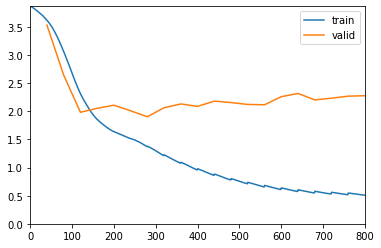

In [0]:
learn.fit_one_cycle(20, max_lr=3e-3)

## 4.5 PyTorch nn.RNN

เราจะใช้ RNN สำเร็จรูปจาก PyTorch ที่เหมือนกับโค้ดด้านบน แต่ภายในจะมี Optimize อะไรอีกนิดหน่อย เช่น [DropOut](https://www.bualabs.com/archives/1533/what-is-dropout-benefits-dropout-reduce-overfit-deep-learning-training-model-deep-neural-network-regularization-ep-2/) จะอธิบายต่อไป

In [0]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.RNN(nh, nh, batch_first=True)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()

    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()               
        return self.h_o(self.bn(res))

In [0]:
learn = Learner(data, Model4(), metrics=[accuracy], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.379947,3.108656,0.309943,00:00
1,2.723461,2.240447,0.456605,00:00
2,2.106261,1.984713,0.433026,00:00
3,1.759663,2.008790,0.316974,00:00
4,1.565449,1.789742,0.461364,00:00
5,1.396146,1.599111,0.511719,00:00
6,1.192534,1.451566,0.553622,00:00
7,0.955861,1.328435,0.590412,00:00
8,0.757268,1.322794,0.595881,00:00
9,0.612197,1.339875,0.606534,00:00


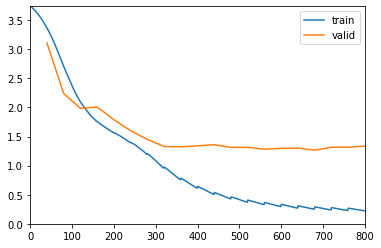

In [0]:
learn.fit_one_cycle(20, max_lr=3e-3)

## 4.6 GRU 

จาก Vanilla RNN เราจะเปลี่ยนไปใช้ Gated Recurrent Unit (GRU) ที่ซับซ้อนยิ่งขึ้น เปรียบเทียบดูว่าประสิทธิภาพจะเป็นอย่างไร

[GRU คืออะไร](https://www.bualabs.com/archives/3103/what-is-recurrent-neural-network-rnn-pytorch-gru-nlp-ep-9/) จะอธิบายต่อไป

In [0]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.GRU(nh, nh, 1, batch_first=True)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()

    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()               
        return self.h_o(self.bn(res))

In [0]:
learn = Learner(data, Model5(), metrics=[accuracy], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.537620,3.397273,0.243040,00:00
1,2.476423,2.172773,0.326705,00:00
2,1.830405,1.902532,0.374645,00:00
3,1.365324,1.428957,0.606179,00:00
4,0.913514,1.182785,0.696662,00:00
5,0.580062,1.073155,0.721875,00:00
6,0.374687,1.166049,0.701918,00:00
7,0.256084,1.207110,0.699574,00:00
8,0.191481,1.113889,0.710014,00:00
9,0.158174,1.095850,0.715838,00:00


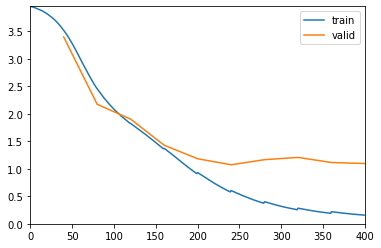

In [0]:
learn.fit_one_cycle(10, max_lr=3e-3)

## 4.7 GRU จาก PyTorch nn.GRUCell

เราจะสร้าง GRU ขึ้นมาเอง โดยประกอบขึ้นมาจาก GRUCell ของ PyTorch

แต่เหมือนกับด้านบน เราจะต้องวน Loop คำนวนให้ครบมิติเวลา BPTT เอง

In [0]:
def rnn_loop(cell, h, x):
    res = []
    for x_ in x.transpose(0, 1):
        h = cell(x_, h)
        res.append(h)
    return torch.stack(res, dim=1)

In [0]:
class Model6(Model5):
    def __init__(self):
        super().__init__()
        self.rnnc = nn.GRUCell(nh, nh)
        self.h = torch.zeros(bs, nh).cuda()

    def forward(self, x):
        res = rnn_loop(self.rnnc, self.h, self.i_h(x))
        self.h = res[:, -1].detach()
        return self.h_o(self.bn(res))

In [0]:
learn = Learner(data, Model6(), metrics=[accuracy], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.441546,3.189493,0.260511,00:00
1,2.444460,2.297956,0.318253,00:00
2,1.835996,1.892758,0.377983,00:00
3,1.413481,1.565133,0.548722,00:00
4,0.961094,1.183301,0.673935,00:00
5,0.607936,1.116616,0.702557,00:00
6,0.389425,1.016415,0.736009,00:00
7,0.263867,1.080819,0.727344,00:00
8,0.194678,1.122433,0.706960,00:00
9,0.159316,1.106163,0.713778,00:00


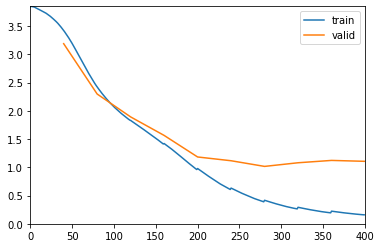

In [0]:
learn.fit_one_cycle(10, max_lr=3e-3)

## 4.8 GRU จาก GRUCell สร้างเอง

เราจะสร้าง GRU ขึ้นมาเอง โดยประกอบขึ้นมาจาก GRUCell ที่เราเขียนเอง

แต่เหมือนกับด้านบน เราจะต้องวน Loop คำนวนให้ครบมิติเวลา BPTT เอง

In [0]:
class GRUCell(nn.Module):
    def __init__(self, ni, nh):
        super(GRUCell, self).__init__()
        self.ni, self.nh = ni, nh
        self.i2h = nn.Linear(ni, 3 * nh)
        self.h2h = nn.Linear(nh, 3 * nh)

    def forward(self, x, h):
        gate_x = self.i2h(x).squeeze()
        gate_h = self.h2h(h).squeeze()
        i_r, i_u, i_n = gate_x.chunk(3, 1)
        h_r, h_u, h_n = gate_h.chunk(3, 1)

        resetgate = torch.sigmoid(i_r + h_r)
        updategate = torch.sigmoid(i_u + h_u)
        newgate = torch.tanh(i_n + (resetgate * h_n))
        return updategate * h + (1 - updategate) * newgate

In [0]:
class Model7(Model6):
    def __init__(self):
        super().__init__()
        self.rnnc = GRUCell(nh, nh)

In [0]:
learn = Learner(data, Model7(), metrics=[accuracy], callback_fns=[ShowGraph])

In [0]:
# learn.lr_find()
# learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,3.444230,3.144925,0.409730,00:01
1,2.458143,2.294758,0.318679,00:01
2,1.825913,1.822744,0.424290,00:01
3,1.361728,1.496997,0.626634,00:01
4,0.890773,1.138155,0.718679,00:01
5,0.555861,1.134625,0.749574,00:01
6,0.356717,1.173079,0.760583,00:01
7,0.244029,1.104342,0.770810,00:01
8,0.182160,1.048848,0.786577,00:01
9,0.150305,1.033103,0.790057,00:01


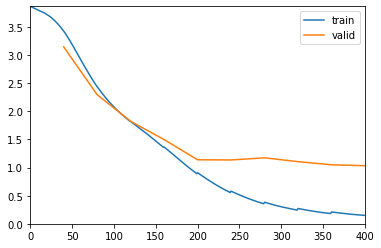

In [0]:
learn.fit_one_cycle(10, max_lr=3e-3)

# 5. สรุป

1. เราได้เรียนรู้การสร้าง Recurrent Neural Network (RNN) จากพื้นฐาน [Neural Network](https://www.bualabs.com/archives/1763/what-is-neural-network-how-neural-network-work-build-deep-neural-network-from-scratch-neural-network-ep-1/) จนใช้งานได้จริง
1. เราได้เปรียบเทียบประสิทธิภาพ จุดเด่น จุดด้อย ของสถาปัตยกรรม RNN ในแบบต่าง ๆ แล้วพัฒนาโมเดลขึ้นมาเรื่อย ๆ ไปจนถึง GRU
1. เราได้ใช้ RNN, GRU ของ PyTorch มาต่อยอดโมเดล ที่เราสร้างขึ้นมาแต่ต้น ให้มีประสิทธิภาพมากขึ้น
1. ถ้าข้อมูลมีขนาดเล็ก โมเดลไม่ซับซ้อน เราสามารถเทรนโดยไม่จำเป็นต้องใช้ GPU ก็ได้ แต่ถ้าจะเทรน Language Model ด้วย Corpus ขนาดใหญ่ ควรวางแผนเตรียมการเทรนโมเดลข้ามคืน

# Credit

* https://www.youtube.com/watch?v=l1rlFh0PmZw&list=PLtmWHNX-gukKocXQOkQjuVxglSDYWsSh9&index=11
* https://www.bualabs.com/archives/2693/data-block-api-data-pipeline-machine-learning-supervised-learning-preprocessing-ep-5/
* https://www.bualabs.com/archives/926/sentiment-analysis-imdb-movie-review-ulmfit-sentiment-analysis-ep-1/
* https://docs.fast.ai/data_block.html
* https://docs.fast.ai/text.data.html
* https://github.com/emadRad/lstm-gru-pytorch/blob/master/lstm_gru.ipynb
* https://pytorch.org/docs/stable/nn.html